In [ ]:
!git clone https://github.com/microsoft/LLaVA-Med.git

Cloning into 'LLaVA-Med'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 429 (delta 1), reused 31 (delta 1), pack-reused 388 (from 1)
Receiving objects: 100% (429/429), 77.09 MiB | 21.87 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
cd LLaVA-Med/

/content/LLaVA-Med


In [61]:
from llava.model.builder import load_pretrained_model
model_path='microsoft/llava-med-v1.5-mistral-7b'
model_base=None
model_name='llava-med-v1.5-mistral-7b'
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_base, model_name, load_8bit=False, load_4bit=False, device="cuda")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of the model checkpoint at microsoft/llava-med-v1.5-mistral-7b were not used when initializing LlavaMistralForCausalLM: ['model.vision_tower.vision_tower.vision_model.embeddings.class_embedding', 'model.vision_tower.vision_tower.vision_model.embeddings.patch_embedding.weight', 'model.vision_tower.vision_tower.vision_model.embeddings.position_embedding.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.layer_norm2.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.bias', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight', 'model.vision_tower.vision_tower.vision_model.encoder.layers.0.mlp.fc2.bias', 'model.vision_tower.vision_tower.vision_model.encoder.la

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 9.06 MiB is free. Process 50569 has 14.74 GiB memory in use. Of the allocated memory 14.56 GiB is allocated by PyTorch, and 47.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
import requests
from PIL import Image
from io import BytesIO

def load_image(image_file):
    if image_file.startswith("http://") or image_file.startswith("https://"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image

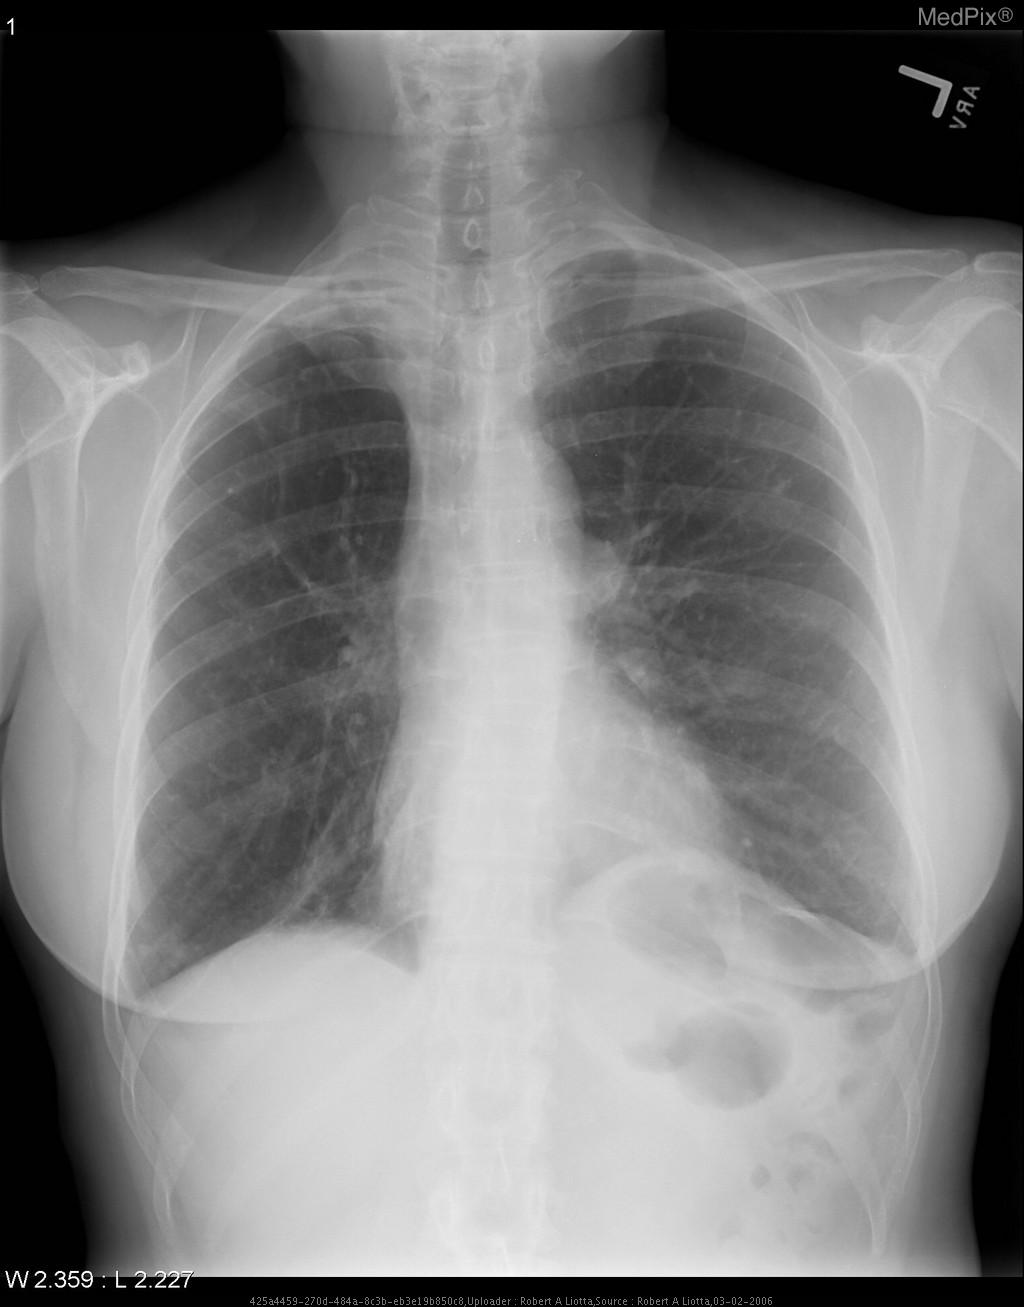

In [ ]:
image = load_image("https://www.kaggleusercontent.com/kf/185531980/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..TlAGMtaLvTIfgXLjasvtvg.feoxe705rWrlg5i2BqxdT1Q7EU4JwFvM-yN-Rb6o94MKAJjM-62VQDTOsEwNxDkkHLd5iC7I55b8Wv66JbpOcwEl3wU8vrlXdtE_I5Ddzq84OC3LUJO19UklGc5OOVPYqiXR8wXS8-lyKh8gw4lyWnWPHgTH2XIrt1L6TFy3dw9XYc1STNVyLP1vjZJqcEmXiHjBOq79Nhjx-FupH3wgnnLN2lUI6d4k-GwdeN9bnSN3GH6UDQcB7xcCqCGZr5hI3aL6tcSN1BzUQP9bd4222huXnSeyepN6D8N-tft9NNPY0LaPO4wtMTB_LjbizXgj_NbXSv-VRmBuDOXbjbs2VDfOKK0etPO5NVtlkalkP5RQwCshjK5enLUizJwAEOoCpqferd3Fh3XoYkvPLgFhjy9TFEXLrUUNGlvtXh7cX2tflGPhaSKVNpeNy4Y6qwiVUgT-UlV8_8zWQVYAsu_ZrUWLMI7mDvpkadyiMQtBfgq0SgEdh7WpPBE6iRhLamgxMdGRA8T_EpQRKjm41L5W2EciV8U2hY8l4JKEeYhWpF_1jEU9QxUgJYhoHGCzLzPqDpV7sKb3OAdJyqgtI8Uz_SJy556An3z0BHQn_wNUlZgaaX-j4gG4Ljfs1kfUTV972wWseAKkoWT7zbT1WmCDjJgpJt4LkGKQ6_l3rcU4pA4.NvjfpyovcVaDf_OAeLU4Ag/__results___files/__results___9_0.png")
image

In [ ]:
if tokenizer.pad_token is None:
  tokenizer.pad_token = tokenizer.eos_token

In [ ]:
import textwrap
from io import BytesIO

import requests
import torch
from llava.constants import DEFAULT_IMAGE_TOKEN, IMAGE_TOKEN_INDEX
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (
    KeywordsStoppingCriteria,
    get_model_name_from_path,
    process_images,
    tokenizer_image_token,
)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from PIL import Image


In [ ]:
def process_image(image):
    args = {"image_aspect_ratio": "pad"}
    image_tensor = process_images([image], image_processor, args)
    return image_tensor.to(model.device, dtype=torch.float16)

processed_image = process_image(image)
type(processed_image), processed_image.shape

(torch.Tensor, torch.Size([1, 3, 336, 336]))

In [ ]:
CONV_MODE = "llava_v0"

In [ ]:
def create_prompt(prompt: str):
    conv = conv_templates[CONV_MODE].copy()
    roles = conv.roles
    prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt
    conv.append_message(roles[0], prompt)

    conv.append_message(roles[1], None)
    return conv.get_prompt(), conv

In [ ]:
prompt, _ = create_prompt("What type of imaging does this not represent?")
print(prompt)

A chat between a curious human and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the human's questions.###Human: <image>
What type of imaging does this not represent?###Assistant:


In [ ]:
def ask_image(image: Image, prompt: str):
    image_tensor = process_image(image)
    prompt, conv = create_prompt(prompt)
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(model.device)
    )

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    stopping_criteria = KeywordsStoppingCriteria(
        keywords=[stop_str], tokenizer=tokenizer, input_ids=input_ids
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=image_tensor,
            do_sample=True,
            temperature=0.01,
            max_new_tokens=512,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
            # pad_token_id=tokenizer.eos_token_id,eos_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(
        output_ids[0, input_ids.shape[1] :], skip_special_tokens=True
    ).strip()

In [ ]:
pip show transformers

Name: transformers
Version: 4.46.2
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers


In [ ]:
result = ask_image(image, "What type of imaging does this not represent?")
print(textwrap.fill(result, width=110))




The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


TypeError: LlavaMistralForCausalLM.forward() got an unexpected keyword argument 'cache_position'